# PIT - Práctica 1: Análisis de Series Temporales - Modelos Clásicos

**Alicia Lozano Díez**
 
13 de febrero de 2023


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento y análisis de señales temporales: descomposición de una serie temporal para el estudio de sus propiedades, ajuste de modelos lineales (ARIMA) y predicción.

### Materiales - Moodle

- Guión (.ipynb) de la práctica
- Datos (.csv): bases de datos _AirPassengers.csv_ y _stocks_1yr.csv_.


# 1. Introducción al procesamiento de señales temporales: Air Passengers

## 1.1. Cargar los datos en Google Colab y manejo de los datos en Python

Primero vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un periodo de tiempo.

Las siguientes líneas de código nos permitirán subir el archivo a Google Colab desde el disco local:

In [191]:
# Comentamos porque ejecutamos en local
#from google.colab import files
#uploaded = files.upload()
import warnings
warnings.filterwarnings('ignore')

A continuación, vamos a leer el fichero *AirPassengers.csv* en Python, con la ayuda de la librería *pandas*.

Lo cargaremos haciendo uso también del módulo de Python *datetime* para operar con este tipo de datos de forma cómoda.

La función definida *parser* nos permitirá cambiar el formato de fecha/tiempo al formato que esperamos encontrar en nuestra base de datos.

In [192]:
from pandas import read_csv
from datetime import datetime
 
def parser(x):
	return datetime.strptime(x, '%Y-%m')
 
data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, 
                squeeze=True, date_parser=parser)
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


Podemos visualizar cómo está indexada la estructura de datos, así como el número de datos que tiene nuestra serie temporal.

In [193]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Si queremos acceder a un dato en concreto, por ejemplo, el número de pasajeros del mes de marzo de 1949, podemos hacerlo de la siguiente forma:

In [194]:
data['1949-03-01']


132

O de esta otra:

In [195]:
data[datetime(1949,3,1)]

132

## 1.2. Representación de los datos


El primer paso para analizar una serie temporal es obtener una representación de los datos, para poder hacernos una idea de las características de la serie de forma visual. 

Para ello, podemos utilizar la librería *matplotlib* como sigue:

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

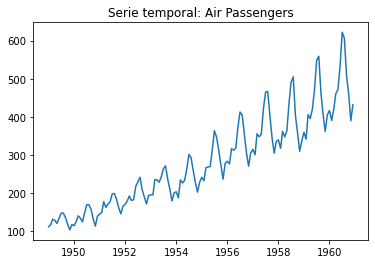

In [196]:
from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.3. Estudio de la estacionariedad de la serie


Algunos de los modelos de análisis de series temporales asumen estacionariedad en las series. Por ello, vamos a ver dos métodos para comprobar si una serie es estacionaria.

Uno de ellos es un análisis más visual: calculamos la media y desviación estándar "móviles" (con una ventana deslizante). 

In [197]:
import pandas as pd

def test_stationarity_1(timeseries, window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation. Window size { window_size}')
    plt.show(block=False)

El segundo método consiste en el test estadístico Dickey-Fuller:

In [198]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [199]:
def test_stationarity(timeseries,window_size):
  test_stationarity_1(timeseries,window_size)
  test_stationarity_2(timeseries)

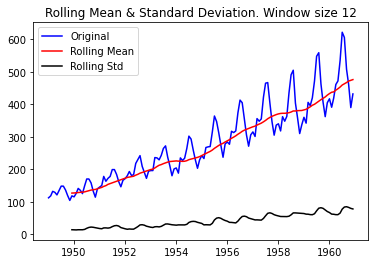

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [200]:
test_stationarity(data,12)

**PREGUNTAS**

1.   ¿Qué conclusiones puede extraer del análisis de estacionariedad de la serie original?

Documentación: 
- https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller
- https://es.wikipedia.org/wiki/Ra%C3%ADz_unitaria

La prueba de Dickey Fuller busca determinar o no la existencia de raíces unitarias 
en una serie de tiempo. La hipótesis nula de la prueba es que existe una raíz unitaria en la serie. 

En caso de tener raíz unitaria la serie será no estacionaria. 

A la vista del resultado estadístico podemos ver que el p-valor es mayor del 0.05 por lo que NO podemos rechazar la hipótesis nula y por tanto la serie es NO estacionaria. 

El resultado estadístico es coherente con la inspección visual de la gráfica, donde se aprecia una tendencia ascendente de la media de los valores. 


2.   ¿Qué diferencias observas al variar el tamaño de la ventana para hacer las medias móviles? Prueba con un par de tamaños, incluye las gráficas obtenidas y explica las diferencias visuales que aprecias.



-------------------- Tamaño de ventana 1


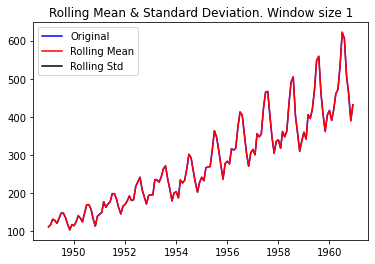

-------------------- Tamaño de ventana 5


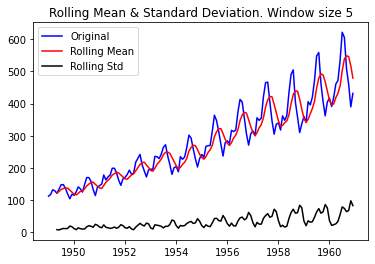

-------------------- Tamaño de ventana 7


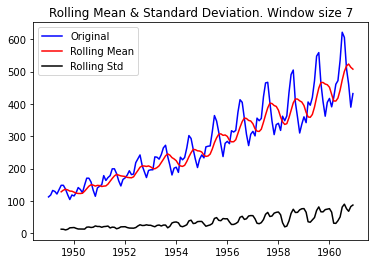

-------------------- Tamaño de ventana 10


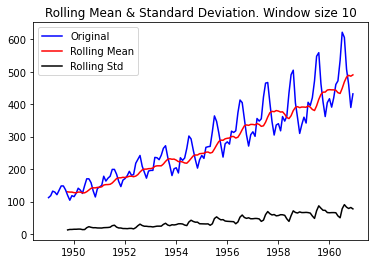

-------------------- Tamaño de ventana 12


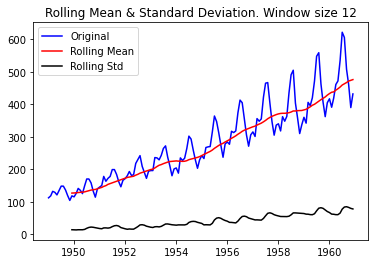

-------------------- Tamaño de ventana 15


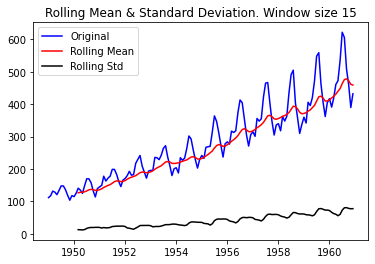

-------------------- Tamaño de ventana 24


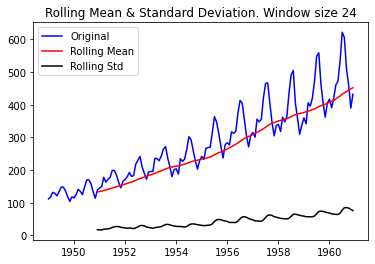

-------------------- Tamaño de ventana 26


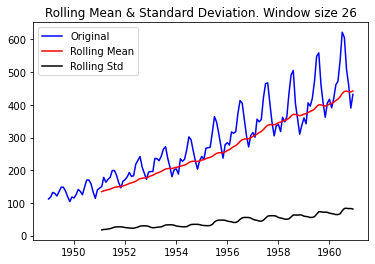

In [201]:
windows_length = [1, 5,7,10,12,15,24, 26]
for w in windows_length:
    print('--'*10,f'Tamaño de ventana {w}')
    test_stationarity_1(data,w)


**Conclusiones sobre el efecto del tamaño de la ventana**

El tamaño de la ventana $k$ es el número de valores anteriores $k-1$ sobre los que se determina el valor de  *rolling mean* y por ende de *rolling std*. 

Es un hiperparámetro cuyo valor no se puede estimar a priori. 

Notemos que que alcanza una forma similar a una recta en el tamaño 12. Esto no es de extrañar ya que estamos muestreando la señal mensualmente y en un año es natural que se presente un periodo estacionario y que su media indique si hay crecimiento o no.

A partir de estas observaciones se puede tomar para otras situaciones la siguiente heurística: 

- En caso de infraestimar el valor de $k$ se puede apreciar que se mantiene una tendencia oscilatoria de la serie. 
- En caso de sobreestimar tal valor estacionario vuelve a aparecer. 
- Si su utiliza un  múltiplo del periodo vemos que el *rolling mean* queda también similar a una recta. 

## 1.4. Transformar una serie temporal en estacionaria

Como hemos visto en la teoría, para analizar la serie y poder ajustarle un modelo tipo AR, MA o ARMA, esperamos que la serie a modelar sea estacionaria. 

Para conseguir una serie lo más estacionaria posible, podemos aplicar distintas transformaciones de la serie original. Vamos a ver algunos ejemplos:

a) *Transformaciones simples para reducir el efecto de la tendendia*:

En el caso de los datos del ejemplo, la tendencia es positiva, por lo que podemos aplicar alguna transformación que penalice los valores más altos y menos los más bajos. Es el caso del logaritmo, la raíz cuadrada, etc. 

**PREGUNTA**


1.   Representa a continuación la serie aplicándole una transformación logarítmica. ¿Qué observas?



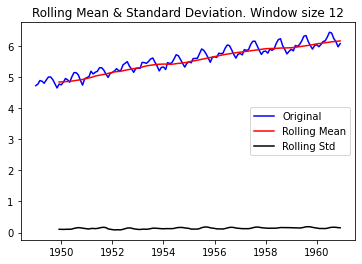

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [202]:
import numpy as np
test_stationarity(np.log(data),12)

En casos más complejos en los que la tendencia no se ve clara (sobre todo en presencia de ruido), se pueden aplicar otros métodos. Uno de ellos es el suavizado como las medias móviles (*moving average*). 

Por ejemplo, podemos aplicar un suavizado con una media con ventana deslizante que tenga en cuenta un año (12 meses). 
Ten en cuenta, que esto implicará que para calcular la media de las primeras muestras, no tengo suficientes datos para la ventana. Esto lo podemos ver en la salida de la media móvil (tendremos que eliminar los *NaN* que aparecen).


**PREGUNTAS**


1.   Aplica dicha media móvil y represéntala junto a los datos. Puede utilizar los datos en escala logarítmica. ¿Esta media móvil representa claramente la tendencia de la serie?

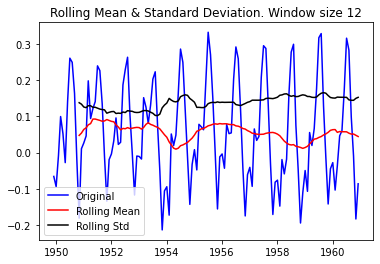

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [203]:
window_length = 12
data_log = data.apply(np.log)

# Esta sería una opción de cálculo de la media 
#means = [ np.mean(data_log[l:l+window_length])
#         for l in range(len(data_log) - window_length)]
# Pero vamos a utilizar el método rolling de dataframe de pandas
# Documentación: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
means = data_log.rolling(window = window_length ).mean().dropna()

data_minus_mean = data_log[window_length -1:] - means

test_stationarity(data_minus_mean,12)

En este caso se puede rechazar que la serie  NO sea estacionaria y de hecho bajo una inspección visual puede intuirse un comportamiento periódico. 

2.   Elimina ahora de la serie original (transformada con el logaritmo si es como la has calculado previamente) la influencia de esta media móvil y representa el resultado. ¿Qué observas ahora?

**Implementación**

La influencia de la media móvil se verá eliminada si restamos la media de los valores (para el tamaño de ventana seleccionado a 12).



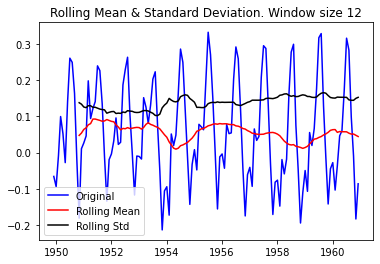

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [204]:
# TODO: No veo la diferencia con el ejercicio anterior, debo de matizarlo de alguna manera
data_log_sin_media_movil = (data_log -data_log.rolling(window = 12).mean().dropna()).dropna()
test_stationarity(data_log_sin_media_movil,12)


3.   Realiza el test de estacionariedad de la serie resultante y compáralo con el de la serie original. ¿Qué conclusiones puedes obtener tanto del test visual como del test estadístico?

In [205]:
# Iker

b) *Diferenciar (derivar)*:

Las técnicas anteriores son sencillas y pueden eliminar parte de la influencia de la tendencia de la serie, pero no suelen ser suficientes cuando se tiene por ejemplo estacionalidad. 

Diferenciar (o derivar) es uno de los métodos más comunes para eliminar la influencia de la tendencia y la estacionalidad en la serie original, mejorando las propiedades de estacionariedad de la serie. 

Podemos tomar la derivada de orden uno de la siguiente manera (partimos de la serie en el dominio logarítmico): 

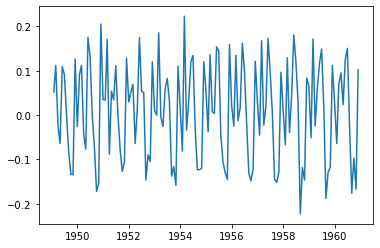

In [206]:
data_log_diff = data_log - data_log.shift()
plt.plot(data_log_diff)
plt.show()

**PREGUNTAS**


1.   ¿Qué observas en la serie resultante?

Puede observarse que la serie está acotada superior e inferiormente, ya que ha sido posible dibujarla en su totalidad en el intervalo menos a $(-0.3, 0.3)$; por lo tanto podría ser bastante factible que fuera estacionaria. 
A priori parece que su media estaría cercana a cero. 

1.   ¿Es esta serie estacionaria de acuerdo a los criterios anteriores? Incluye los resultados gráficos y del test estadístico e interprétalos.

2. Repite el proceso para una segunda derivada. ¿Qué observas ahora?



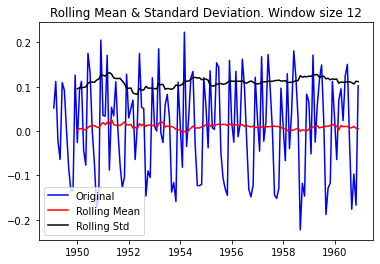

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


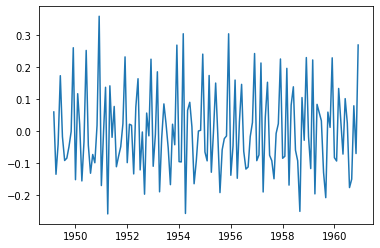

In [207]:
# Apartado 1
test_stationarity(data_log_diff.dropna(), 12)
# 2 Iker
# 3 Iker (me ha dado curiosidad de ver qué pasa )
data_log_diff_2 = data_log_diff - data_log_diff.shift()
plt.plot(data_log_diff_2)

c) *Descomposición de la serie*:

La mayoría de series pueden descomponerse en tendencia, estacionalidad y residuo, como hemos visto en clase. 

Utilizando la función *seasonal_decompose* del módulo de Python *statsmodels* podemos obtener estas tres componentes y por tanto, modelarlas por separado: 

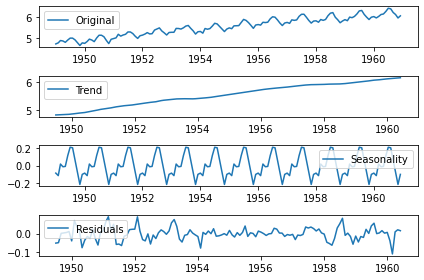

In [208]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**PREGUNTAS**

1.   ¿Es la señal residual estacionaria? Realiza el test y comenta los resultados.



Podemos observar que el p-valor es menor que $3 \times 10^{-8}$ por lo que podemos rechazar la hipótesis nula de que exista una raíz unitaria y por ende la serie es estacionaria. 

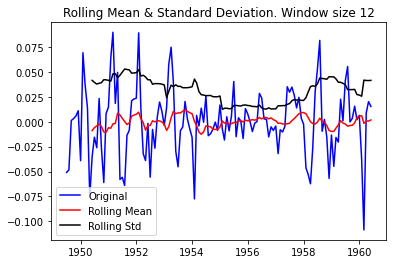

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [209]:
test_stationarity(residual.dropna(), 12)

## 1.5. Modelado ARIMA y predicción

Uno de los modelos clásicos para series temporales vistos en clase es el modelo ARIMA, que permite derivar *d* veces, y aplicar *p* coeficientes autorregresivos (AR) y *q* términos de error (shocks, provenientes de la parte MA) en la combinación lineal.  

Para determinar el valor de los parámetros *p* y *q*, podemos hacer uso de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). 

Si calculamos dichas funciones para la serie derivada previamente, obtenemos lo siguiente:

Text(0.5, 1.0, 'Partial Autocorrelation Function')

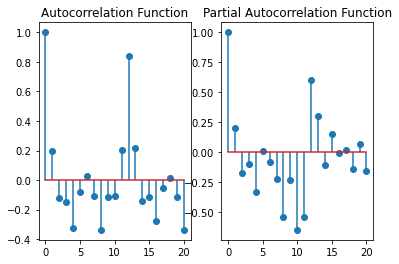

In [210]:
data_log_diff = data_log_diff.dropna()
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

Podemos añadir además un intervalo de confianza a ambos lados del valor cero, de tal manera que el primer valor de retardo que cruce ese intervalo por arriba en la función de PACF será el valor de *p*, y de ACF, será *q*.

Para los niveles de confianza estándar, el valor del límite del intervalo de confianza al 95% es 1.96. Suponiendo desviación estándar unidad, el límite estaría en (-1.96/sqrt(N), 1.96/sqrt(N)), donde N es el número de puntos. 

Si incluimos estos límites en la figura anterior, podemos obtener una buena aproximación de los valores de *p* y *q* para el modelo ARIMA:

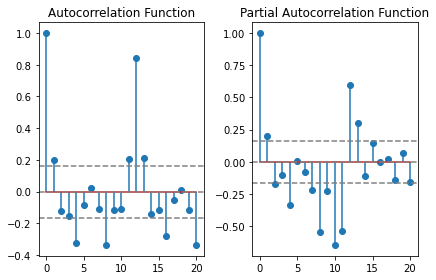

In [211]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


**PREGUNTAS**


1.   ¿Qué valores de *p* y *q* utilizarías para un primer modelo ARIMA de acuerdo a las representaciones anteriores?


**Iker**
**Solución**
De acorde al criterio dado los valores de $p$ y $q$ serían los primeros en superar el umbral prefijado, en este caso sería $p = q = 1$. 



Una vez elegidos los valores de *p* y *q*, podemos utilizar también la derivación interna de la clase ARIMA (*d*) o aplicarlo sobre la serie previamente derivada con valor de *d=0*. 

A continuación, importamos el modelo ARIMA de la siguiente manera. 

Este modelo tiene como argumentos los datos, y el orden: 

model = ARIMA(datos, order = (p,d,q))

In [212]:
from statsmodels.tsa.arima.model import ARIMA
data_log_diff = data_log_diff.resample('MS').last().dropna()

**PREGUNTAS**


1.   A continuación, completa los valores de p, d y q y utiliza el siguiente código para ajustar un modelo tipo AR. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

La función ARIMA ha sido tomada de: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

Para ajustar un modelo de este tipo, de acorde a la documentación vendrá dado por: 
`autoregressive models`: AR(p) y el resto de valores a cero, por lo tanto tenemos que los hiperparámetros vendrán dados por: 
$$
(p, d, q) = (p,0,0)
$$

Para la selección de $p$ vamos a tomar los puntos donde se alcanzaba módulos altos PACF, concretamente algunos de esos puntos son: 

$$
    P = [1,2,4,8,10,12]
$$


Los resultados obtenidos han sido los siguientes: 

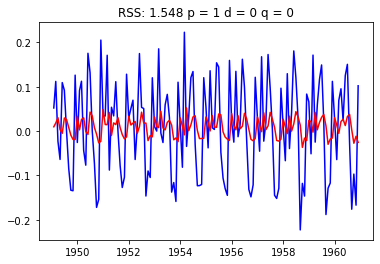

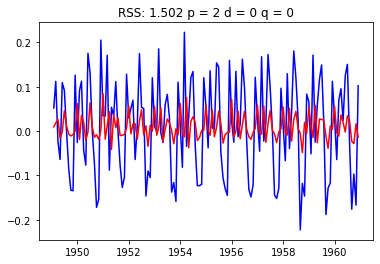

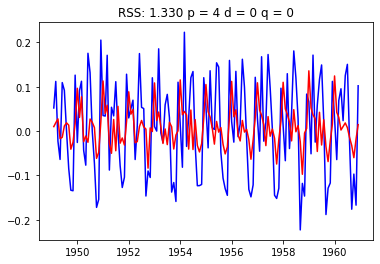

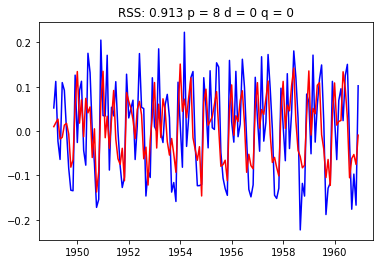

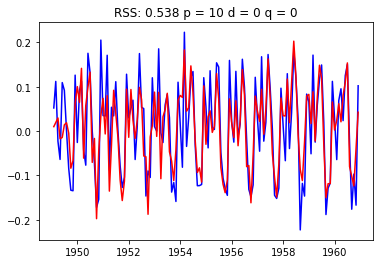

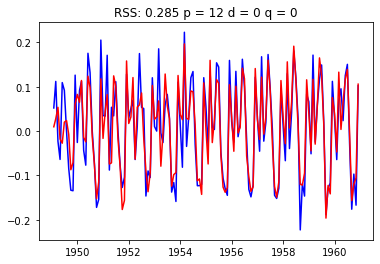

In [213]:
def ajusta_ARIMA(data, p, d, q): 
    # AR
    model = ARIMA(data, order=(p, d, q),  enforce_invertibility=True)  
    results_AR = model.fit() 
    # plotting
    plt.plot(data, color = 'blue', label = 'Original data')
    plt.plot(results_AR.fittedvalues, color='red', label='AR results')
    #print(results_AR.summary())
    RSS = sum((results_AR.fittedvalues - data)**2)
    plt.title(f'RSS: {RSS:.3f} '+ 
              f'p = {p} d = {d} q = {q}')
    plt.show() 
    # RSS: Residual sum of squares
    return results_AR, RSS

# Probamos otros valores de p
P = [1,2,4,8,10,12]
RSS_AR = []
for p in P:
    _, rss = ajusta_ARIMA(data_log_diff, p,0,0)
    RSS_AR.append(((p,0),rss))

In [214]:
print('Los errores obtenidos en AR son:')
print('(p,q) | RSS ')
for v,rss in RSS_AR:
    print(v, ' | ', f'{rss :.3f}')

Los errores obtenidos en AR son:
(p,q) | RSS 
(1, 0)  |  1.548
(2, 0)  |  1.502
(4, 0)  |  1.330
(8, 0)  |  0.913
(10, 0)  |  0.538
(12, 0)  |  0.285


Como era de esperar para un orden p=1 el error ha sido relativamente algo RSS = 1.548, conforme aumentamos el orden el error disminuye, alcanzando el menor observado en $p=12$ con $RSS = 0.285$.

2.    Repite el código con los valores de los parámetros correspondientes para ajustar un modelo MA. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?


Para este caso los q que vamos a probar son 

Autocorrelation function 
$$
Q = [1,4,11,12,13, 16]
$$

Las conclusiones son parecidas al anterior, el error disminuye conforme aumenta el orden, sin embargo el error mínimo que alcanzamos es mayor que el anterior: 
para $q = 16$ se tiene $RSS = 0.556$

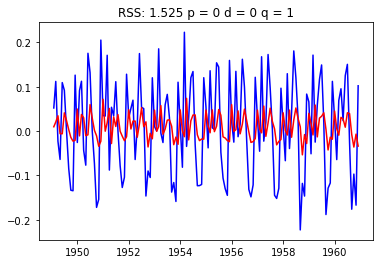

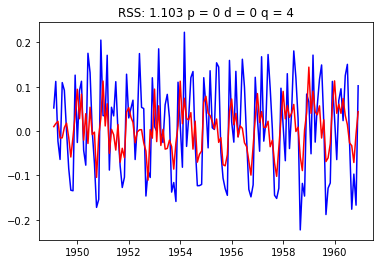

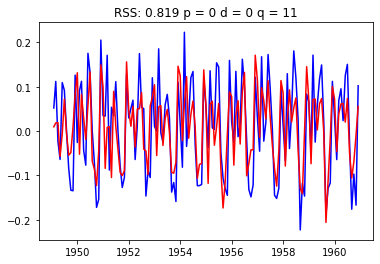

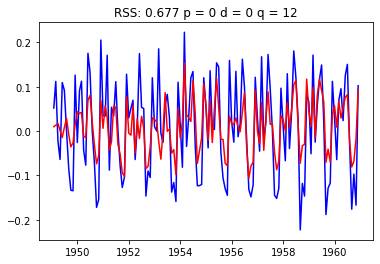

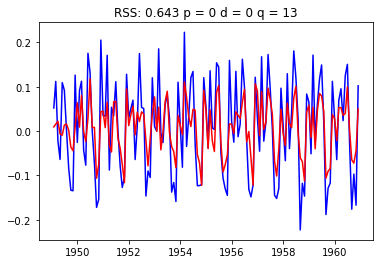

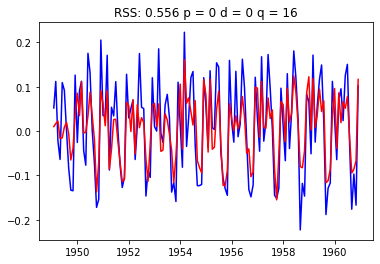

In [215]:

Q = [1,4,11,12,13, 16]
RSS_MA = []
for q in Q:
    _ , rss = ajusta_ARIMA(data_log_diff, 0,0,q)
    RSS_MA.append(((0,q),rss))


In [216]:
print('Los errores obtenidos en MA son:')
print('(p,q) | RSS ')
for v,rss in RSS_MA:
    print(v, ' | ', f'{rss :.3f}')

Los errores obtenidos en MA son:
(p,q) | RSS 
(0, 1)  |  1.525
(0, 4)  |  1.103
(0, 11)  |  0.819
(0, 12)  |  0.677
(0, 13)  |  0.643
(0, 16)  |  0.556



3.    Repite nuevamente el código para combinar los modelos anteriores (ARMA). Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?


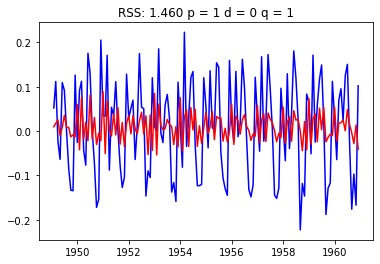

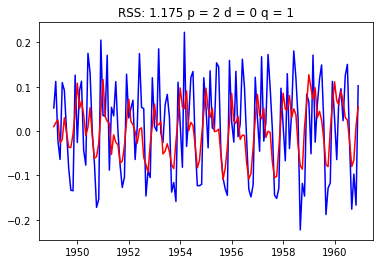

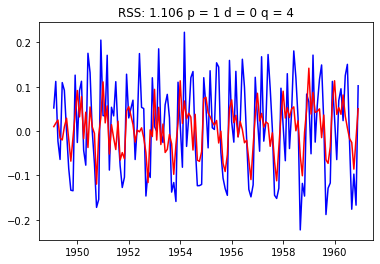

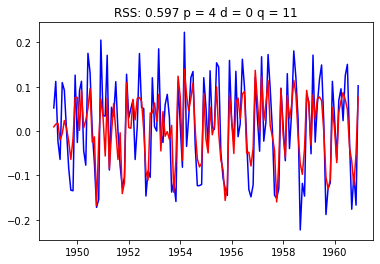

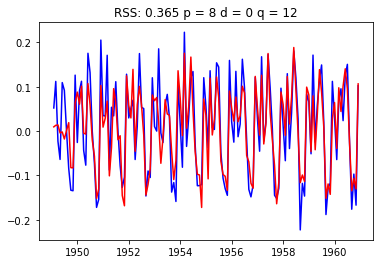

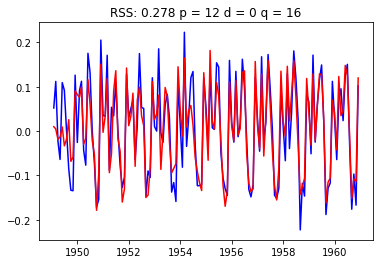

In [217]:
#P = [1,2,4,8,10,12]
#Q = [1,4,11,12,13, 16]
RSS_ARMA = []
for p,q in [(1,1), (2,1),(1,4), (4,11),(8,12),(12,16)]:
    _ , rss = ajusta_ARIMA(data_log_diff, p,0,q)
    RSS_ARMA.append(((p,q),rss))  



In [218]:
print('Los errores obtenidos en ARMA son:')
print('(p,q) | RSS ')
for v,rss in RSS_ARMA:
    print(v, ' | ', f'{rss :.3f}')


Los errores obtenidos en ARMA son:
(p,q) | RSS 
(1, 1)  |  1.460
(2, 1)  |  1.175
(1, 4)  |  1.106
(4, 11)  |  0.597
(8, 12)  |  0.365
(12, 16)  |  0.278


4.   De acuerdo a los valores de RSS, ¿cuál dirías que es el modelo que mejor se ajusta a los datos?

Si tenemos en mente los valores de AR podemos aprecias que son 

In [219]:
print('Los errores obtenidos en AR son:')
print('(p,q) | RSS ')
for v,rss in RSS_AR:
    print(v, ' | ', f'{rss :.3f}')

Los errores obtenidos en AR son:
(p,q) | RSS 
(1, 0)  |  1.548
(2, 0)  |  1.502
(4, 0)  |  1.330
(8, 0)  |  0.913
(10, 0)  |  0.538
(12, 0)  |  0.285


Son ligeramente peores por lo tanto afirmamos que el modelos ARMA es el más adecuado. 

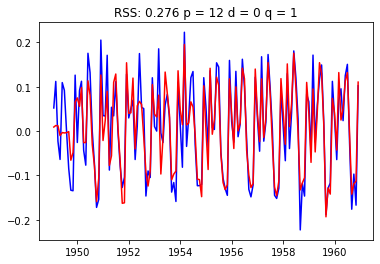

In [220]:
# Reducimos orden para evitar sobreajuste
results_ARIMA, rss = ajusta_ARIMA(data_log_diff, 12,0,1)

Por último, para predecir valores en el espacio original, tenemos que deshacer las transformaciones realizadas hasta el momento. 

Primero, tomamos los valores ajustados por el modelo (predicciones) y los guardamos como serie temporal. 

Estos valores empiezan en el segundo mes, puesto que hemos tomado diferencias (derivada) de orden 1.

In [221]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Month
1949-02-01    0.009125
1949-03-01    0.012524
1949-04-01    0.011864
1949-05-01   -0.010287
1949-06-01   -0.003355
Freq: MS, dtype: float64


Segundo, deshacemos la operación de diferencias (en escala logarítmica), con una suma acumulativa y añadiéndoles el valor "base" (primer elemento de la serie). 

In [222]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009125
1949-03-01    0.021648
1949-04-01    0.033512
1949-05-01    0.023225
1949-06-01    0.019870
Freq: MS, dtype: float64


In [223]:
predictions_ARIMA_log = pd.Series(data_log[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.727623
1949-03-01    4.740147
1949-04-01    4.752011
1949-05-01    4.741724
dtype: float64


Finalmente, aplicamos la función exponencial (inversa del logaritmo).

Podemos calcular el error cuadrático medio en el espacio original. 

Text(0.5, 1.0, 'RMSE: 89.7072')

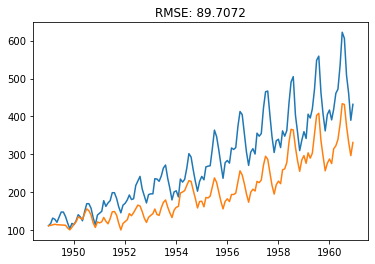

In [224]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

# 2. Aplicación a otros datos: Acciones en bolsa S&P 500 stock data


Vamos a cargar ahora los datos sobre las acciones en bolsa del fichero *stocks_1yr.csv*:

In [225]:
#from google.colab import files
#uploaded = files.upload()

Esta base de datos contiene los datos para las acciones (*stocks*) de un año, y por columnas, contiene los siguientes campos: 


* Date - en formato: yy-mm-dd

* Open - precio de la acción en la apertura de la bolsa

* High - precio más alto alcanzado en el día

* Low Close - precio más bajo en el día

* Volume - Número de acciones vendidas/compradas

* Name - Nombre de la compañía

In [226]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
data = read_csv('stocks_1yr.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(data.head())

             open   high    low  close    volume Name
date                                                 
2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


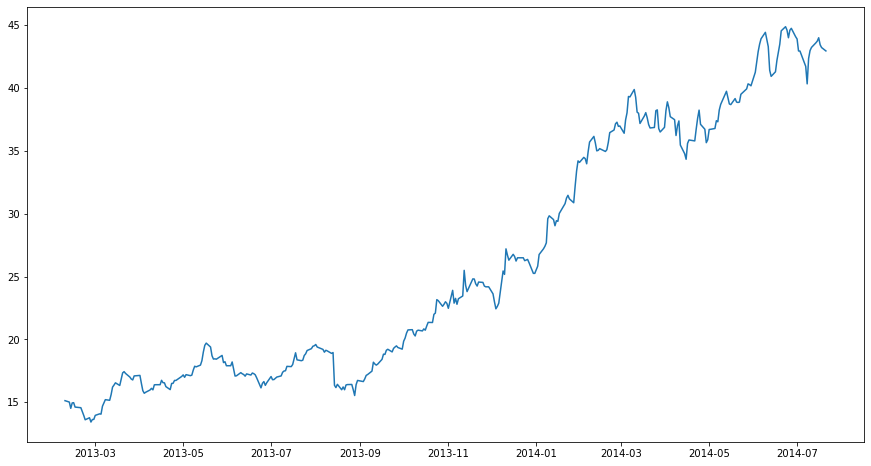

In [227]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(data.high)

**PREGUNTAS**

Utilizando las herramientas del apartado 1, realiza el análisis de esta serie (puedes utilizar un intervalo de ella o la serie completa). 

En concreto:
1.   Analiza la estacionariedad de esta serie. 
2.   ¿Qué transformaciones puedes realizar para hacerla más estacionaria? Prueba algunas y justifica si consigues una serie más estacionaria. 
3.   Ajusta un modelo ARIMA, y calcula el error de predicción. 



### Análisis de la estacionalidad 

Comenzaremos viendo si la serie es  estacionaria, a simple vista ya se intuye que no y el test estadístico indica que no lo es. 

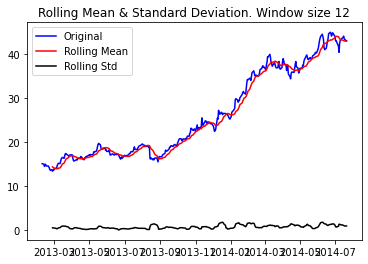

Results of Dickey-Fuller Test:
Test Statistic                   0.239126
p-value                          0.974373
#Lags Used                       3.000000
Number of Observations Used    360.000000
Critical Value (1%)             -3.448646
Critical Value (5%)             -2.869602
Critical Value (10%)            -2.571065
dtype: float64


In [228]:
test_stationarity(data.high,12)

El cremiento de acorde al tiempo no recuerda a ciertas funciones básica, 
porbaremos a realizar su transformación. 

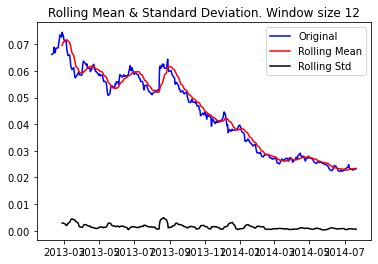

Results of Dickey-Fuller Test:
Test Statistic                  -0.743688
p-value                          0.835107
#Lags Used                       0.000000
Number of Observations Used    363.000000
Critical Value (1%)             -3.448494
Critical Value (5%)             -2.869535
Critical Value (10%)            -2.571029
dtype: float64


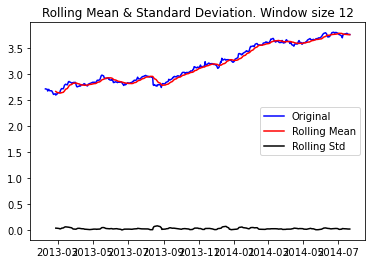

Results of Dickey-Fuller Test:
Test Statistic                  -0.320296
p-value                          0.922580
#Lags Used                       1.000000
Number of Observations Used    362.000000
Critical Value (1%)             -3.448544
Critical Value (5%)             -2.869557
Critical Value (10%)            -2.571041
dtype: float64


In [229]:
def transformation(data, function):
    transformed_data = function(data)
    test_stationarity(transformed_data,12)
    return transformed_data

inversa = lambda x: 1/(x)

transformation(data.high, inversa)
_ = transformation(data.high, np.log)

No hemos llegado a nada así que probaremos a diferenciar la serie: 

Para la derivada 1 se tiene: 


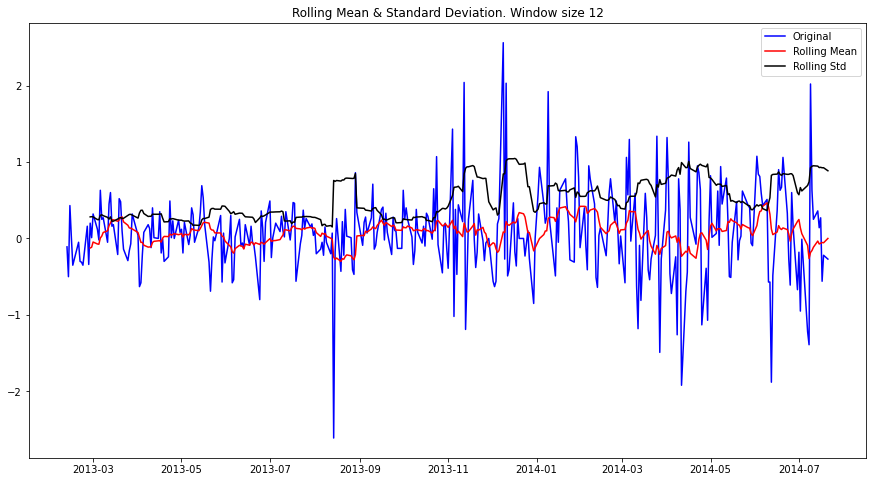

Results of Dickey-Fuller Test:
Test Statistic                -1.179631e+01
p-value                        9.560899e-22
#Lags Used                     2.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


In [230]:
data_diff = data.high
for d in range(1,2): # con una es suficiente
    print(f'Para la derivada {d} se tiene: ')
    data_diff = data_diff - data_diff.shift()
    data_diff = data_diff.dropna()
    plt.figure(figsize=(15,8))
    test_stationarity(data_diff,12)
    
    

Como vemos ahora la serie es estacionaria. 
Si descomponemos la serie podemos observar: 


In [231]:
type(data.high)

pandas.core.series.Series

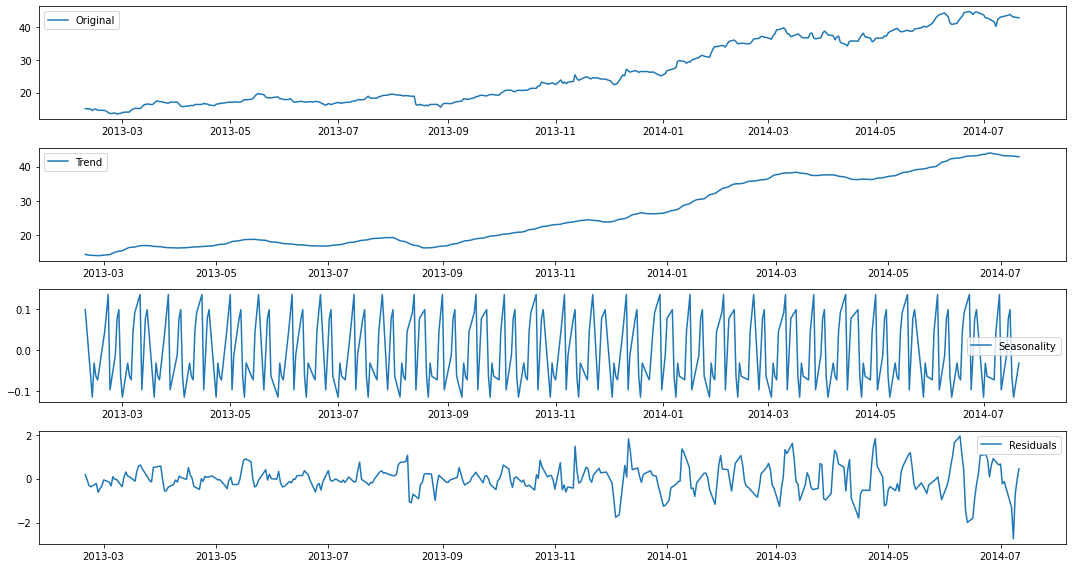

In [240]:
decomposition = seasonal_decompose(data.high, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(data.high, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Aunque el residuo es estacionario (ver celda anterior), la tendencia no parece seguir un modelo lineal y la parte seasonal es despreciable ya que es bastante menor que el ruido (por lo tanto descartamos modelo SARIMA). 

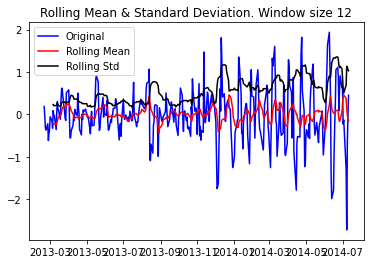

Results of Dickey-Fuller Test:
Test Statistic                -8.841720e+00
p-value                        1.661550e-14
#Lags Used                     1.200000e+01
Number of Observations Used    3.390000e+02
Critical Value (1%)           -3.449788e+00
Critical Value (5%)           -2.870104e+00
Critical Value (10%)          -2.571332e+00
dtype: float64


In [233]:
# vemos si el residuo es estacionario
test_stationarity(residual.dropna(), 12)

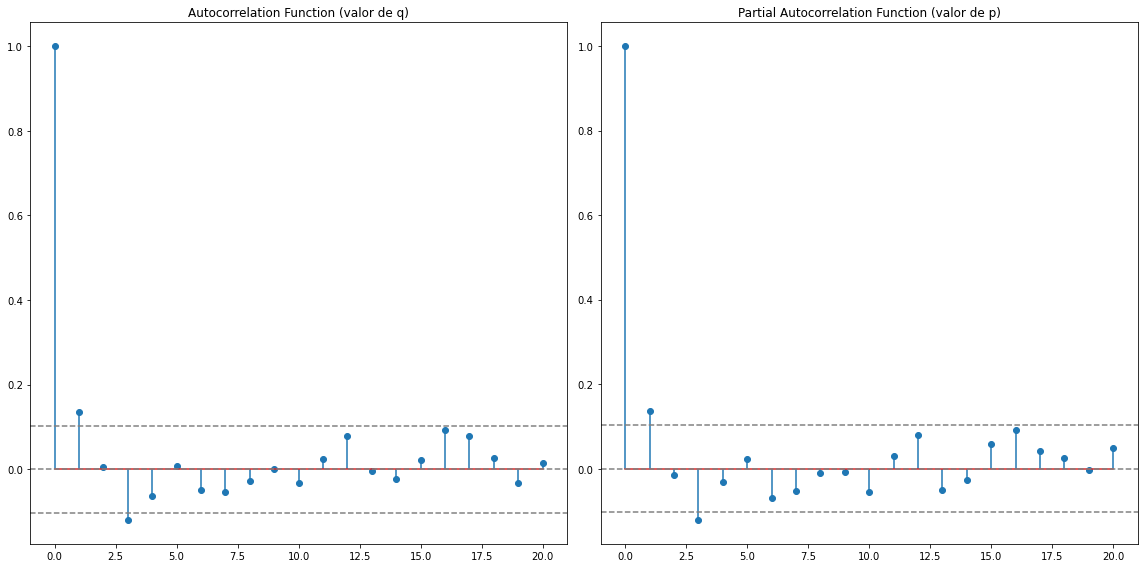

In [234]:
def plot_correlaciones(data_log_diff):
    lag_acf = acf(data_log_diff, nlags=20, fft=False)
    lag_pacf = pacf(data_log_diff, nlags=20, method='ols')
    
    plt.figure(figsize=(16,8))
    #Plot ACF: 
    plt.subplot(121) 
    plt.stem(lag_acf,use_line_collection=True)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function (valor de q)')

    #Plot PACF:
    plt.subplot(122)
    plt.stem(lag_pacf,use_line_collection=True)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function (valor de p)')
    plt.tight_layout()
    plt.show()

plot_correlaciones(data_diff)

A la vista de estos resultados podemos determinar que 
$Q = [1,3]$
$P = [1,4]$

Ajustamos el modelo de ARIMA:

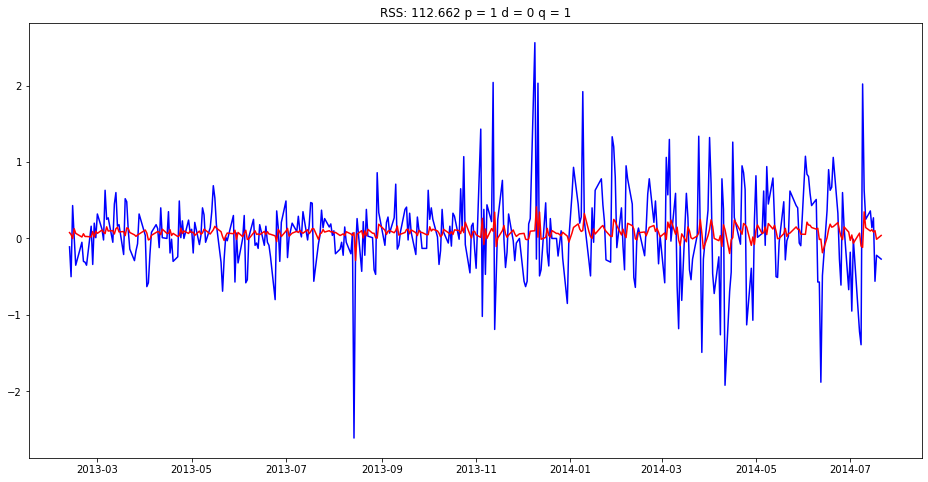

date
2013-02-11    0.076453
2013-02-12    0.051185
2013-02-13   -0.001125
2013-02-14    0.127482
2013-02-15    0.066874
dtype: float64
date
2013-02-11    0.076453
2013-02-12    0.127638
2013-02-13    0.126513
2013-02-14    0.253995
2013-02-15    0.320869
dtype: float64


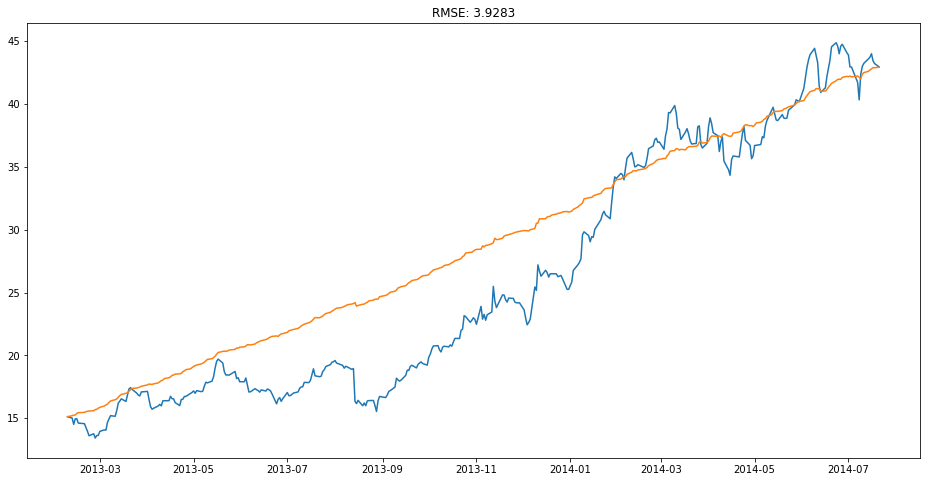

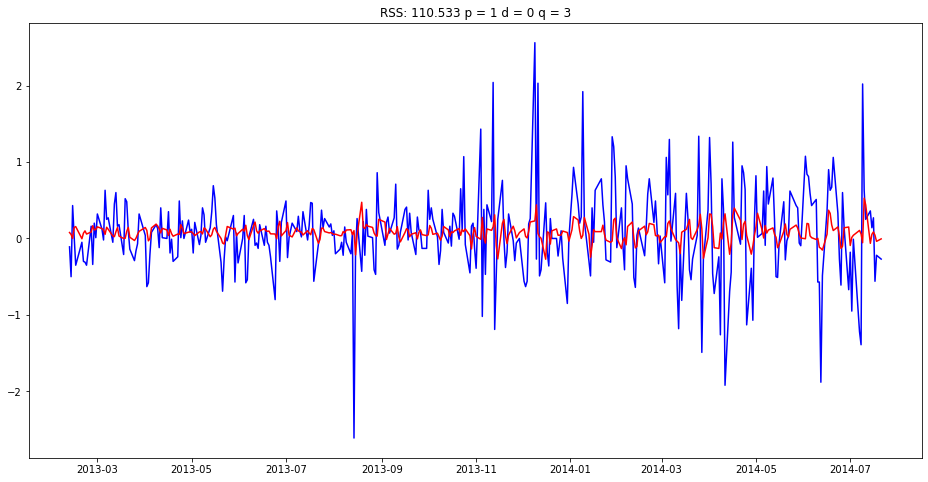

date
2013-02-11    0.077612
2013-02-12    0.052273
2013-02-13    0.000437
2013-02-14    0.144266
2013-02-15    0.155033
dtype: float64
date
2013-02-11    0.077612
2013-02-12    0.129885
2013-02-13    0.130322
2013-02-14    0.274588
2013-02-15    0.429622
dtype: float64


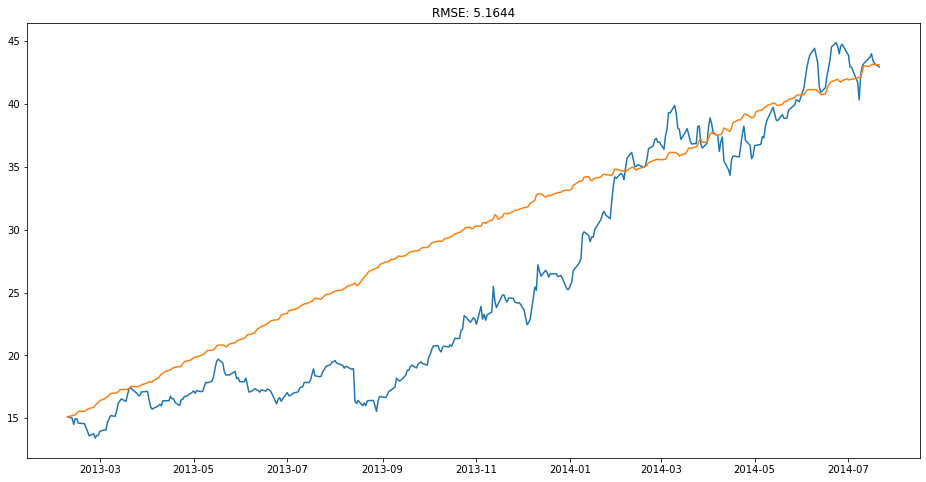

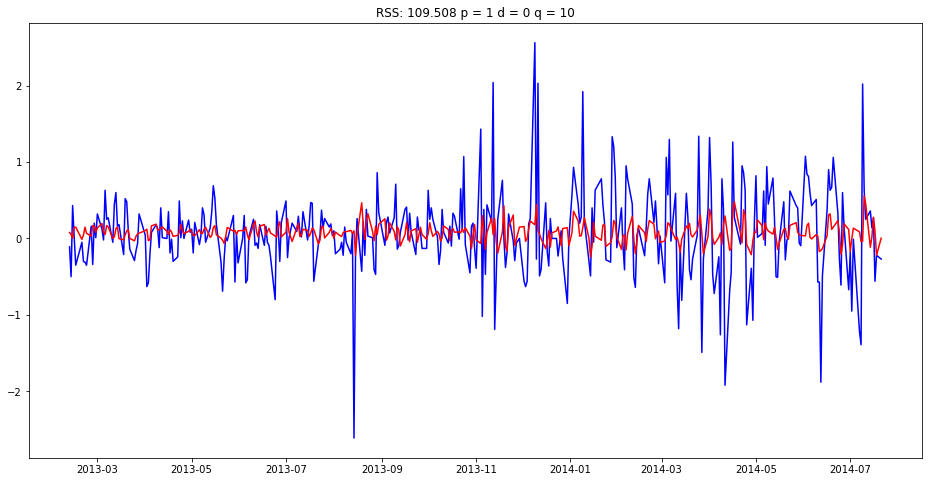

date
2013-02-11    0.077822
2013-02-12    0.052682
2013-02-13    0.002036
2013-02-14    0.147127
2013-02-15    0.148215
dtype: float64
date
2013-02-11    0.077822
2013-02-12    0.130504
2013-02-13    0.132540
2013-02-14    0.279667
2013-02-15    0.427882
dtype: float64


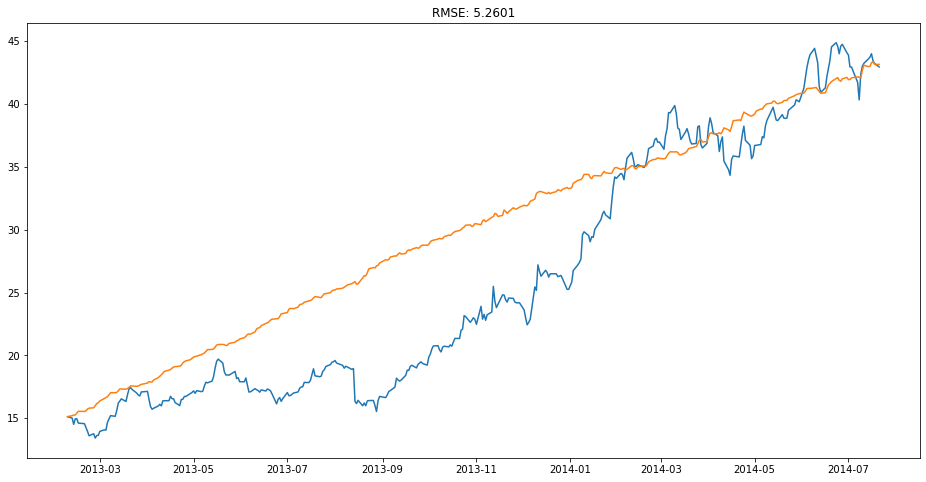

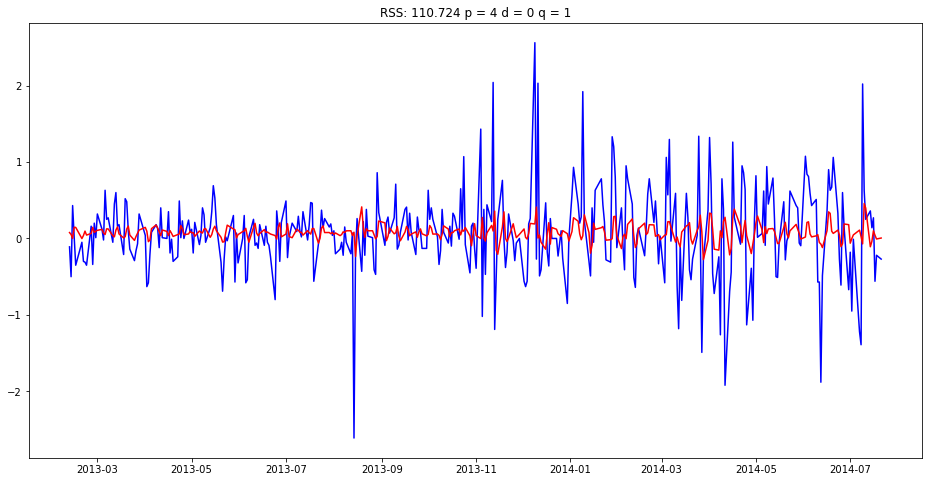

date
2013-02-11    0.077084
2013-02-12    0.051787
2013-02-13    0.000574
2013-02-14    0.146012
2013-02-15    0.144633
dtype: float64
date
2013-02-11    0.077084
2013-02-12    0.128871
2013-02-13    0.129445
2013-02-14    0.275457
2013-02-15    0.420091
dtype: float64


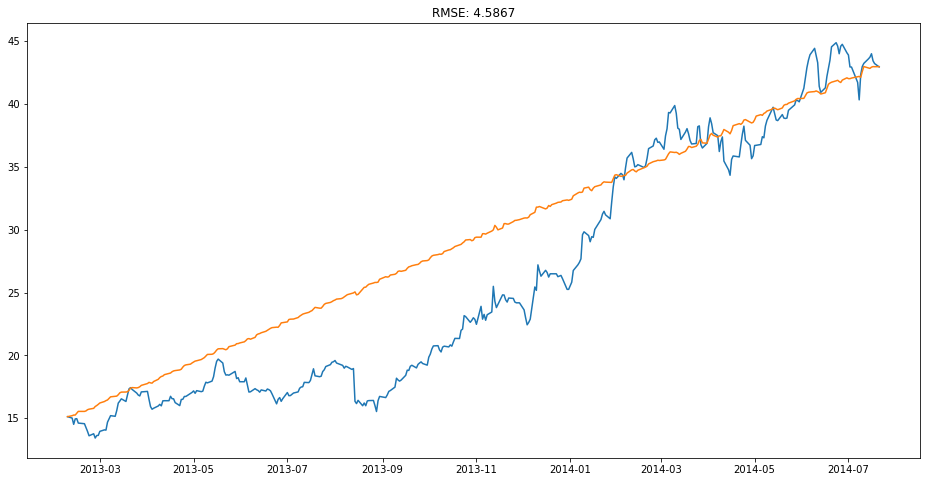

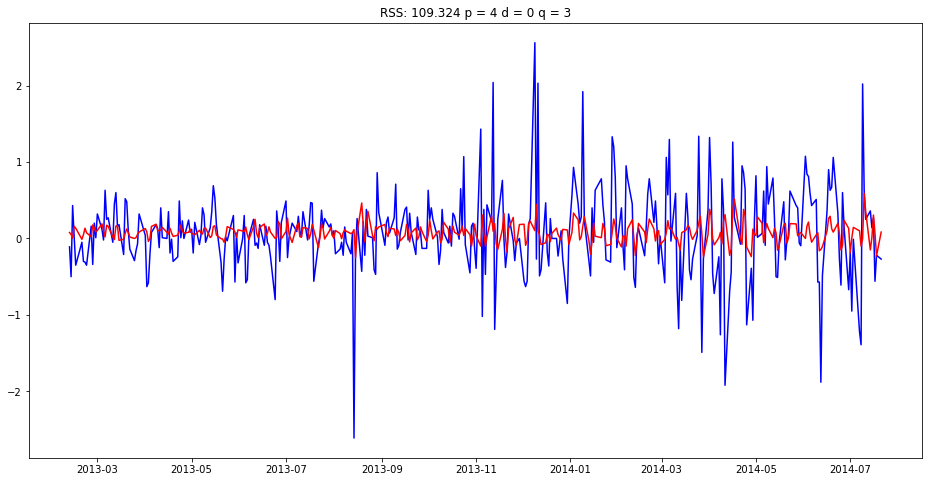

date
2013-02-11    0.077752
2013-02-12    0.052462
2013-02-13    0.003782
2013-02-14    0.158407
2013-02-15    0.134579
dtype: float64
date
2013-02-11    0.077752
2013-02-12    0.130214
2013-02-13    0.133996
2013-02-14    0.292403
2013-02-15    0.426982
dtype: float64


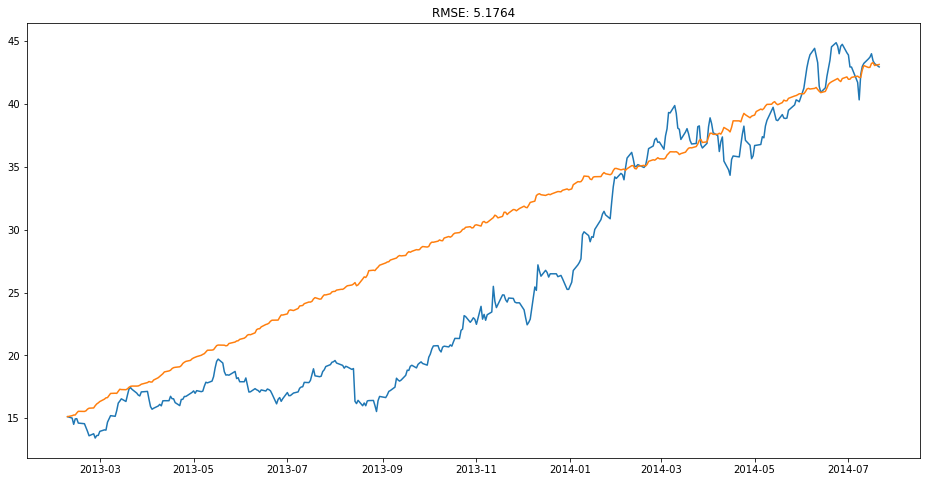

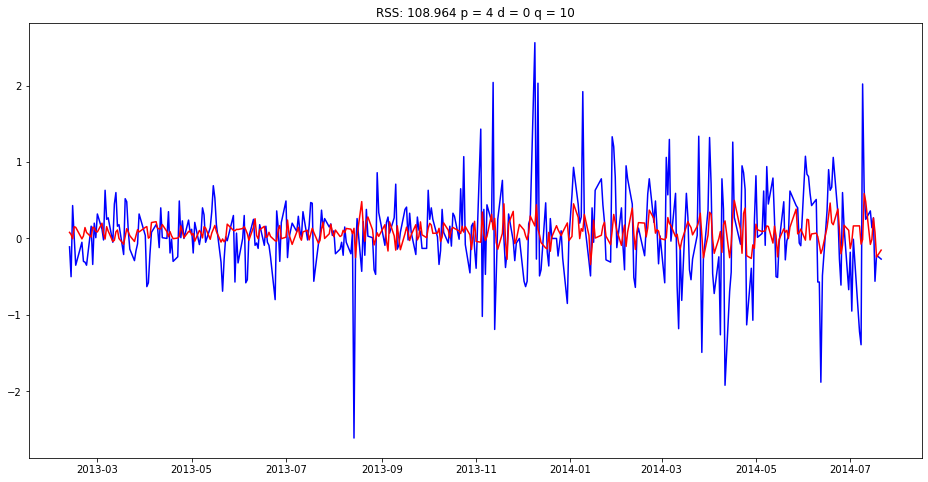

date
2013-02-11    0.079555
2013-02-12    0.051555
2013-02-13   -0.004372
2013-02-14    0.153243
2013-02-15    0.145773
dtype: float64
date
2013-02-11    0.079555
2013-02-12    0.131109
2013-02-13    0.126738
2013-02-14    0.279981
2013-02-15    0.425754
dtype: float64


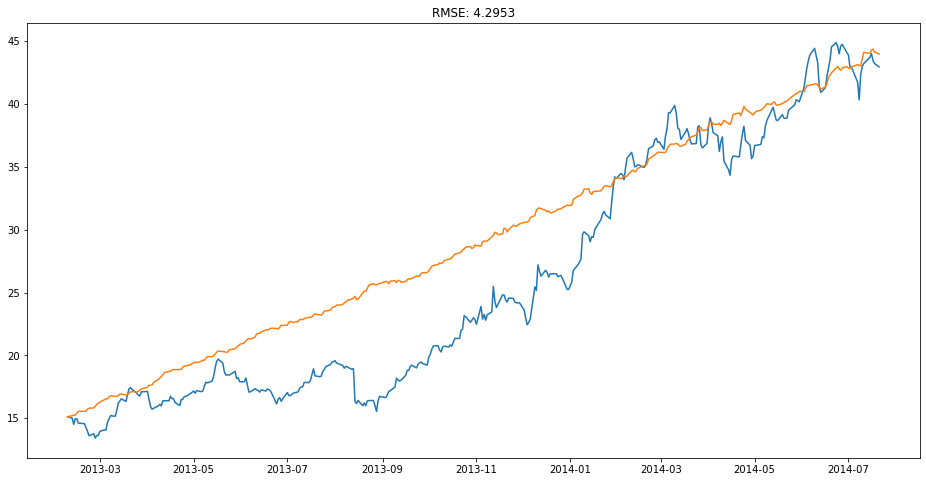

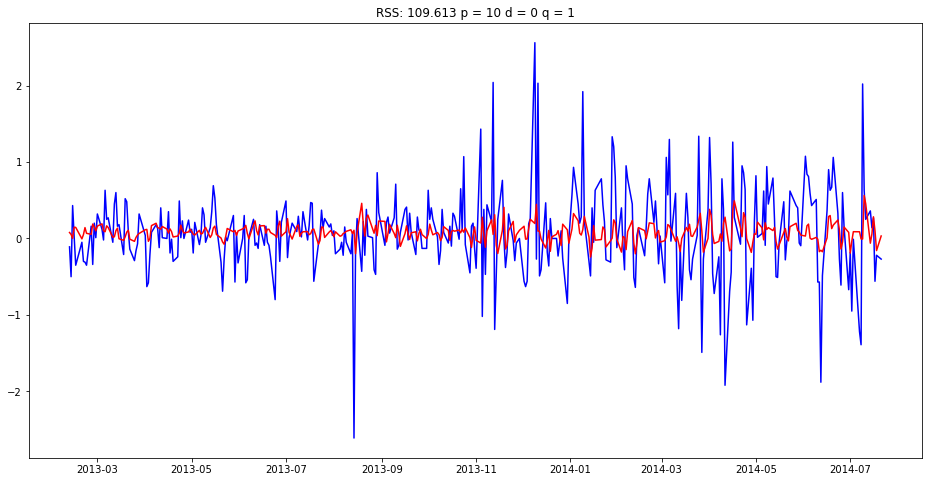

date
2013-02-11    0.077760
2013-02-12    0.052420
2013-02-13    0.001316
2013-02-14    0.146639
2013-02-15    0.144704
dtype: float64
date
2013-02-11    0.077760
2013-02-12    0.130180
2013-02-13    0.131496
2013-02-14    0.278135
2013-02-15    0.422839
dtype: float64


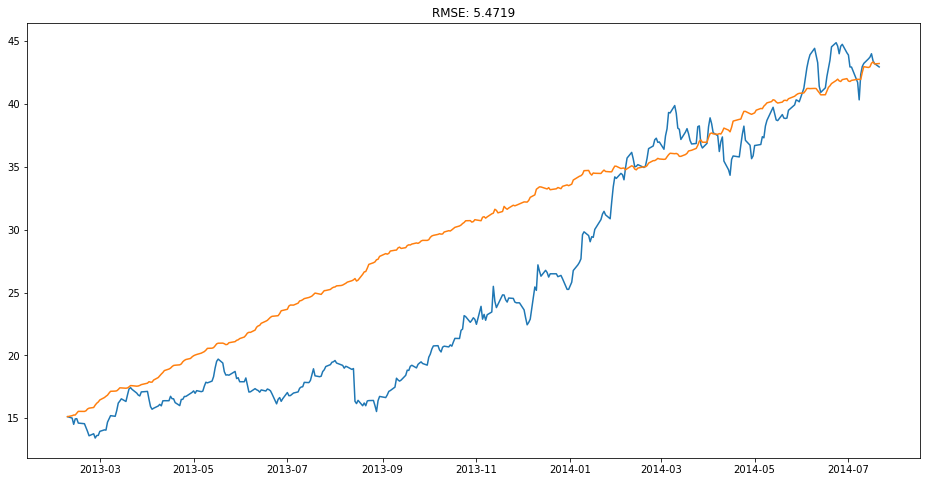

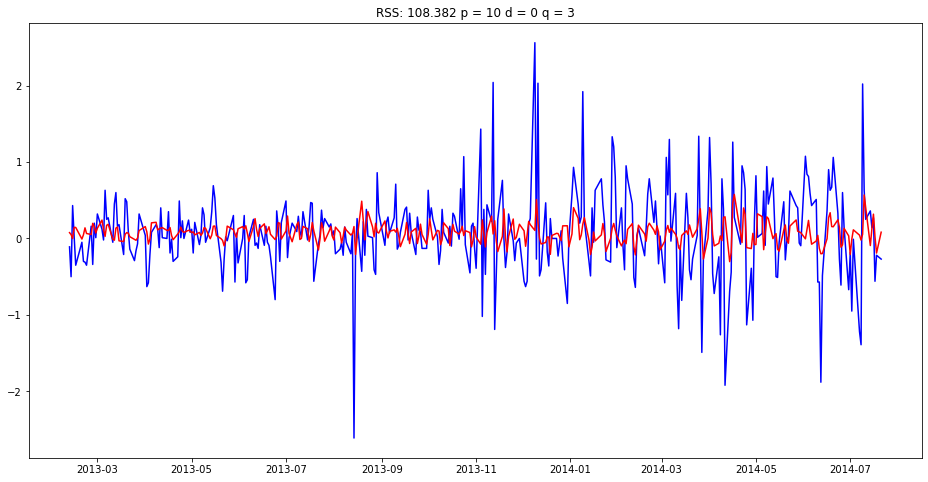

date
2013-02-11    0.075982
2013-02-12    0.050583
2013-02-13   -0.001294
2013-02-14    0.144866
2013-02-15    0.144059
dtype: float64
date
2013-02-11    0.075982
2013-02-12    0.126566
2013-02-13    0.125272
2013-02-14    0.270138
2013-02-15    0.414196
dtype: float64


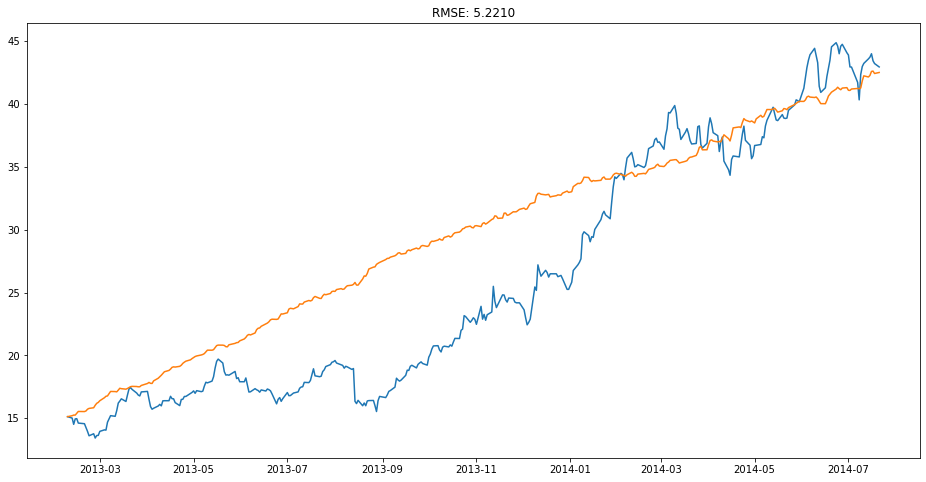

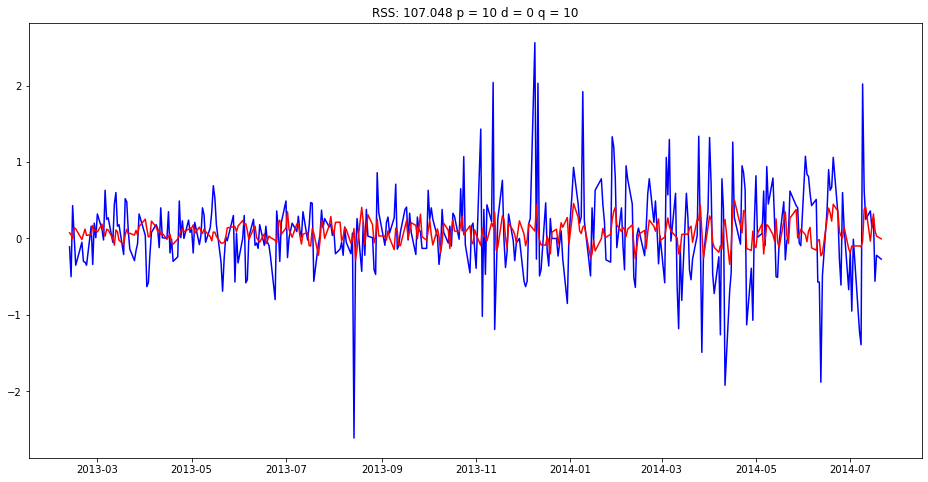

date
2013-02-11    0.073538
2013-02-12    0.048546
2013-02-13   -0.003238
2013-02-14    0.139969
2013-02-15    0.126078
dtype: float64
date
2013-02-11    0.073538
2013-02-12    0.122084
2013-02-13    0.118845
2013-02-14    0.258815
2013-02-15    0.384892
dtype: float64


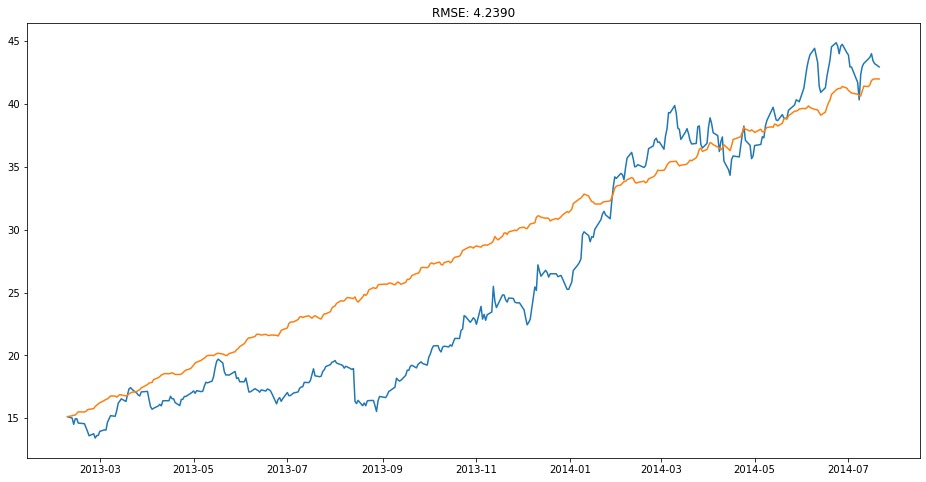

In [239]:
for p in [1,4]:
    for q in [1,3]:
        plt.figure(figsize=(16,8))
        results_ARIMA, rss = ajusta_ARIMA(data_diff, p,0,q)
        plt.show()
        # Predicciones en el espacio original
        predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
        print(predictions_ARIMA_diff.head())
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        print(predictions_ARIMA_diff_cumsum.head())
        predictions_ARIMA = pd.Series(data.high[0], index=data.high.index)
        predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
        plt.figure(figsize=(16,8))
        plt.plot(data.high)
        plt.plot(predictions_ARIMA)
        plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data.high)**2)/len(data)))